In [498]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import chisquare
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report


from model import LDM

In [11]:
def create_holdout(Aij, holdout_ratio=0.1, seed=42):
    Aij_train = Aij.clone()
    if seed is not None:
        random.seed(seed)

    Aij_np = Aij.cpu().numpy()
    pos_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j] > 0]
    neg_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j]==0]

    # select holdtout cases randomly
    n_holdout_pos = int(len(pos_cases)*holdout_ratio)
    n_holdout_neg = int(len(neg_cases)*holdout_ratio)

    holdout_pos = random.sample(pos_cases, n_holdout_pos)
    holdout_neg = random.sample(neg_cases, n_holdout_neg)

    holdouts = holdout_pos + holdout_neg
    random.shuffle(holdouts)
    for i, j in holdouts:
        Aij_train[i,j]=0.0
    return Aij_train, holdouts

In [500]:
class ModelEvaluate:
    def __init__(self, model, Aij_true, test_indices=None):
        self.model = model
        self.Aij_true = Aij_true
        self.test_indices = test_indices

        self.n_drugs, self.n_effects = Aij_true.shape
        self.n_ordinal_classes = Aij_true.max().int().item() +1

    def _get_predictions(self):
        self.model.eval_mode = True
        with torch.no_grad():
            preds, probs = self.model.predict_categories()
            preds_np = preds.cpu().numpy()
            probs_np = probs.cpu().numpy()
        return preds_np, probs_np

    def _get_predictions_bin(self):
        preds_np, _ = self._get_predictions()
        preds_np_bin = np.where(preds_np > 0, 1, 0)
        return preds_np_bin

    def _get_true_values(self):
        Aij_true_np = self.Aij_true.detach().cpu().numpy()
        return Aij_true_np
    
    def _get_true_values_bin(self):
        Aij_np_bin = self._get_true_values()
        Aij_np_bin = np.where(Aij_np_bin > 0, 1, 0)
        return Aij_np_bin

    def _get_true_probs(self):
        Aij_true = self.Aij_true
        n_drugs, n_effects = Aij_true.shape
        n_ordinal_classes = Aij_true.max().int().item() +1
        Aij_true_flat = Aij_true.clone().reshape(-1)
        Aij_true_flat = F.one_hot(Aij_true_flat.long(), n_ordinal_classes)
        Aij_true_probs = Aij_true_flat.view(n_drugs, n_effects, n_ordinal_classes).permute(2, 0, 1)
        return Aij_true_probs

    def evaluate_binary(self):
        preds_np = self._get_predictions_bin()
        true_np = self._get_true_values_bin()

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true_np[i, j])
                pred_vals.append(preds_np[i, j])
        else:
            for i in range(true_np.shape[0]):
                for j in range(true_np.shape[1]):
                    true_vals.append(true_np[i, j])
                    pred_vals.append(preds_np[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class1(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds1 = np.where(preds == 1, 1, 0)
        true1 = np.where(true == 1, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true1[i, j])
                pred_vals.append(preds1[i, j])
        else:
            for i in range(true1.shape[0]):
                for j in range(true1.shape[1]):
                    true_vals.append(true1[i, j])
                    pred_vals.append(preds1[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def evaluate_class2(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds2 = np.where(preds == 2, 1, 0)
        true2 = np.where(true == 2, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true2[i, j])
                pred_vals.append(preds2[i, j])
        else:
            for i in range(true2.shape[0]):
                for j in range(true2.shape[1]):
                    true_vals.append(true2[i, j])
                    pred_vals.append(preds2[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class3(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds3 = np.where(preds == 3, 1, 0)
        true3 = np.where(true == 3, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true3[i, j])
                pred_vals.append(preds3[i, j])
        else:
            for i in range(true3.shape[0]):
                for j in range(true3.shape[1]):
                    true_vals.append(true3[i, j])
                    pred_vals.append(preds3[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def NMI_basic(self):
        Aij_pred, _ = self._get_predictions()
        Aij_true = self._get_true_values()
        #compute edges
        edges = torch.nonzero(torch.tensor(Aij_true) >= 0, as_tuple=False)

        true_labels = []
        pred_labels = []
        for i, j in edges:
            true_labels.append(Aij_true[i,j])
            pred_labels.append(Aij_pred[i,j])
        
        #P(c|c')
        #joint distribution (when are entries in Aij_true and Aij_pred equal)
        n_classes = int(Aij_true.max().item()+1)
        joint_counts = np.zeros((n_classes, n_classes))

        for c, c_mark in zip(true_labels, pred_labels):
            joint_counts[int(c), int(c_mark)] += 1
        joint_probs = joint_counts/ joint_counts.sum()

        #P(c) and P(c')
        p_c = np.sum(joint_probs, axis=1)
        p_c_mark = np.sum(joint_probs, axis=0)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark *np.log(p_c_mark + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(n_classes):
            for c_mark in range(n_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
    
        return NMI, joint_probs
    
    def NMI_advanced(self):
        """ 
        Should run two models e.g one with holdout and one without. Input is the probabilities of each entry being in each class (e.i. the probit matrix)
        """
        _, probs = self._get_predictions()
        Aij_true_probs = self._get_true_probs()
        Aij_probs = Aij_true_probs.detach().cpu().numpy()

        joint_probs = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                joint_probs += np.outer(Aij_probs[:, i, j], probs[:, i, j])
                
        joint_probs /= (self.n_drugs*self.n_effects)

        joint_true = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))
        joint_pred = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))

        for i in range(self.n_drugs):
             for j in range(self.n_effects):
                  joint_true += np.outer(Aij_probs[:, i, j], Aij_probs[:, i, j])
                  joint_pred += np.outer(probs[:, i, j], probs[:, i, j])

        joint_true /= (self.n_drugs * self.n_effects)
        joint_pred /= (self.n_drugs * self.n_effects)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(joint_true * np.log(joint_true + 1e-8))
        H_c_mark = -np.sum(joint_pred *np.log(joint_pred + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(self.n_ordinal_classes):
            for c_mark in range(self.n_ordinal_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (joint_true[c] * joint_pred[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
        #kald som mutual information til sig selv
        return NMI, joint_probs
    
    def plot_heatmap(self):
        _, joint_probs = self.NMI_advanced()
        plt.figure(figsize=(10,8))
        sns.heatmap(joint_probs, annot=True, fmt=".2f", cmap="rocket_r",
                xticklabels=[f"Pred {i}" for i in range(joint_probs.shape[1])],
                yticklabels=[f"True {i}" for i in range(joint_probs.shape[0])],
                linewidths=0.5, linecolor='gray')
        plt.title("Heatmap of Joint Distribution P(c|c')")
        plt.xlabel("Predicted Class (c')")
        plt.ylabel("True Class (c)")
        plt.tight_layout()
        plt.show()


    def plot_confusion(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        
        # Flatten inputs
        preds_flat = preds.flatten()
        true_flat = true.flatten()
        
        labels = [0, 1, 2, 3]
        cm = confusion_matrix(true_flat, preds_flat, labels=labels)
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r', xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Ordinal Class Confusion Matrix")
        plt.show()
        
        # Calculate and print metrics
        print("\nClassification Report:")
        print(classification_report(true_flat, preds_flat, labels=labels, digits=3))

        # Optional: calculate and display accuracy per class
        total_samples = len(true_flat)
        print("Accuracy per class:")
        for i in labels:
            class_mask = true_flat == i
            class_acc = (preds_flat[class_mask] == i).sum() / class_mask.sum() if class_mask.sum() > 0 else 0.0
            print(f"Class {i}: {class_acc:.3f}")

    def plot_confusion_percent(self):
        preds,_ = self._get_predictions()#.round().astype(int).flatten()
        true = self._get_true_values()#.flatten()
        cm = confusion_matrix(true.flatten(), preds.flatten(), labels=[0, 1, 2, 3])
        cm_row_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_row_percent, annot=True, cmap='rocket_r')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Ordinal Class Confusion Matrix")
        plt.show()

    def plot_class_distribution(self, plot=True):
        true_flat = self._get_true_values().flatten()
        pred, _ = self._get_predictions()
        pred_flat = pred.flatten()

        # Get union of all classes
        all_classes = np.unique(np.concatenate([true_flat, pred_flat]))

        true_counts = {c: np.sum(true_flat == c) for c in all_classes}
        pred_counts = {c: np.sum(pred_flat == c) for c in all_classes}

        total_true = sum(true_counts.values())
        total_pred = sum(pred_counts.values())

        true_probs = {c: true_counts[c] / total_true for c in all_classes}
        pred_probs = {c: pred_counts[c] / total_pred for c in all_classes}

        if plot:
            x = np.arange(len(all_classes))
            true_vals = [true_probs.get(c, 0) for c in all_classes]
            pred_vals = [pred_probs.get(c, 0) for c in all_classes]

            bar_width = 0.35

            fig, ax = plt.subplots(figsize=(8, 5))
            ax.bar(x - bar_width/2, true_vals, width=bar_width, label='True', alpha=0.8)
            ax.bar(x + bar_width/2, pred_vals, width=bar_width, label='Predicted', alpha=0.8)

            ax.set_xticks(x)
            ax.set_xticklabels([str(int(c)) for c in all_classes])
            ax.set_xlabel('Class')
            ax.set_ylabel('Probability')
            ax.set_title('Class Probability Distribution')
            ax.legend()
            ax.grid(axis='y', linestyle='--', alpha=0.5)
            ax.set_ylim(0, 1)
            plt.tight_layout()
            plt.show()

        return {
        "true_probs": true_probs,
        "pred_probs": pred_probs
    }

    def compare_class_distributions(self):
            """
            Compare predicted and true class distributions using chi-square test.

            Returns:
                p_value: p-value from chi-square test
                dicts: (true_probs, pred_probs) as dictionaries
            """
            true_data = self._get_true_values().flatten()
            pred_data, _ = self._get_predictions().flatten()

            # Get aligned class labels
            all_classes = sorted(set(np.unique(true_data)).union(np.unique(pred_data)))

            # Count frequencies for both
            true_counts = np.array([np.sum(true_data == c) for c in all_classes])
            pred_counts = np.array([np.sum(pred_data == c) for c in all_classes])

            # Chi-square test
            chi2_stat, p_value = chisquare(f_obs=pred_counts, f_exp=true_counts)

            # Normalize to get probs
            true_probs = {c: true_counts[i]/true_counts.sum() for i, c in enumerate(all_classes)}
            pred_probs = {c: pred_counts[i]/pred_counts.sum() for i, c in enumerate(all_classes)}

            return p_value, true_probs, pred_probs


In [51]:
def train_and_evaluate_bin(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr):
    results = []

    # Store standard deviations
    std_aucs = []
    std_prs = []
    for D in embedding_dims:
        auc_rocs = []
        auc_prs = []
        for i in range(10): 
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed = i)
            #Aij_train = Aij
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()
            
            evaluator = ModelEvaluate(model, Aij)
            auc_roc, auc_pr = evaluator.evaluate_class1()
            auc_rocs.append(auc_roc)
            auc_prs.append(auc_pr)

        std_auc_roc = np.std(auc_rocs)
        std_auc_pr = np.std(auc_prs)
        results.append((D, np.mean(auc_rocs), np.mean(auc_prs)))
        std_aucs.append(std_auc_roc)
        std_prs.append(std_auc_pr)
        print(f"D={D} | MEAN-AUC-ROC: {np.mean(auc_rocs):.3f} ± {std_auc_roc:.3f} | MEAN-AUC-PR: {np.mean(auc_prs):.3f} ± {std_auc_pr:.3f}")

    return results, std_aucs, std_prs
    
def plot_auc(results, std_aucs, std_prs):
    dims, auc_rocs, auc_prs = zip(*results)

    plt.figure(figsize=(10, 5))
    plt.errorbar(dims, auc_rocs, yerr=std_aucs, label='AUC-ROC', marker='o', capsize=5)
    plt.errorbar(dims, auc_prs, yerr=std_prs, label='AUC-PR', marker='s', capsize=5)
    plt.xlabel("Latent Dimension (D)")
    plt.ylabel("Score")
    plt.title("Model Performance vs Latent Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def train_and_evaluate_simple(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr, classes=[0, 1, 2, 3]):
    results = []
    class_acc_dict = {c: [] for c in classes}

    for D in embedding_dims:
        all_class_acc = {c: [] for c in classes}

        for i in range(10): 
            #Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            model = LDM(Aij, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            preds, _ = evaluator._get_predictions()
            true = evaluator._get_true_values()

            class_stats = {c: {'correct': 0, 'total': 0} for c in classes}

            for x in range(preds.shape[0]):
                for y in range(preds.shape[1]):
                    pred_val = preds[x, y]
                    true_val = true[x, y]
                    if pred_val in classes:
                        if pred_val == true_val:
                            class_stats[pred_val]['correct'] += 1
                        class_stats[pred_val]['total'] += 1

            for c in classes:
                correct = class_stats[c]['correct']
                total = class_stats[c]['total']
                acc = correct / total if total > 0 else 0
                all_class_acc[c].append(acc)

        # Mean accuracy across seeds for each class
        for c in classes:
            class_acc_dict[c].append(np.mean(all_class_acc[c]))

        results.append((D, {c: np.mean(all_class_acc[c]) for c in classes}))

    return results, class_acc_dict
    
def plot_class_accuracy(embedding_dims, acc_dict):
    for c in acc_dict:
        plt.plot(embedding_dims, acc_dict[c], marker='o', label=f"Class {c}")

    plt.xlabel("Embedding Dimension")
    plt.ylabel("Mean Accuracy")
    plt.title("Accuracy per Class vs Embedding Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
def NMI_advanced(Aij_probs_true, Aij_probs_pred):
        """ 
        Should run two models e.g one with holdout and one without. Input is the probabilities of each entry being in each class (e.i. the probit matrix)
        """
        Aij_probs_true = Aij_probs_true.detach().cpu().numpy()
        Aij_probs_pred = Aij_probs_pred.detach().cpu().numpy()
        n_ordinal_classes, n_drugs, n_effects = Aij_probs_true.shape

        joint_probs = np.zeros((n_ordinal_classes, n_ordinal_classes))

        for i in range(n_drugs):
            for j in range(n_effects):
                joint_probs += np.outer(Aij_probs_true[:, i, j], Aij_probs_pred[:, i, j])
                
        joint_probs /= (n_drugs*n_effects)

        joint_true = np.zeros((n_ordinal_classes, n_ordinal_classes))
        joint_pred = np.zeros((n_ordinal_classes, n_ordinal_classes))

        for i in range(n_drugs):
             for j in range(n_effects):
                  joint_true += np.outer(Aij_probs_true[:, i, j], Aij_probs_true[:, i, j])
                  joint_pred += np.outer(Aij_probs_pred[:, i, j], Aij_probs_pred[:, i, j])

        joint_true /= (n_drugs * n_effects)
        joint_pred /= (n_drugs * n_effects)

        p_c = np.sum(joint_probs, axis=1)       # shape (n_classes,)
        p_c_mark = np.sum(joint_probs, axis=0)  # shape (n_classes,)

        # Compute entropy
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark * np.log(p_c_mark + 1e-8))

        # Compute mutual information
        MI = 0
        for c in range(n_ordinal_classes):
            for c_mark in range(n_ordinal_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2 * MI / (H_c + H_c_mark + 1e-8)

        return NMI, joint_probs

In [ ]:
def test_embedding_dims(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr):
    results = []
    std_NMIs = []

    for D in embedding_dims:
        NMIs = []
        for i in range(20):
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            Aij_probs_pred = evaluator._get_predictions()[1]
            Aij_probs_true = evaluator._get_true_probs()

            NMI, _ = NMI_advanced(Aij_probs_true, Aij_probs_pred)
            NMIs.append(NMI)

        mean_NMI = np.mean(NMI)
        std_NMI = np.std(NMI)
        results.append((D, mean_NMI))
        std_NMIs.append(std_NMI)

        print(f"D={D} | MEAN-NMI: {mean_NMI:.4f} ± {std_NMI:.4f}")
    return results, std_NMIs

In [40]:
from model import LDM

In [415]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

class LDMP(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=None):
        super(LDMP, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item() +1

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.gamma = nn.Parameter(torch.randn(1, device=device))
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    

    def get_thresholds(self):
        # Ensure thresholds remain positive and increasing
        deltas = torch.softmax(self.beta_thilde, dim = 0)  # Ensure positive increments
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def probit(self):
        # #n_ordinal_classes = len(self.thresholds) - 1
        # #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_ordinal_classes, self.n_drugs, self.n_effects), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = self.gamma + linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[y, :, :] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    
    def predict_categories(self):
        probit_matrix = self.probit()  # Call probit to get probabilities
        return torch.argmax(probit_matrix, dim=0), probit_matrix
    
    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        freqs = torch.tensor([686320,   5107,   2645,   5928], dtype=torch.float32, device= self.device)
        class_weights = 1.0 / (freqs + 1e-6)  # Avoid div by 0
        class_weights = class_weights / class_weights.sum()
        probit_matrix = self.probit() 
        # Initialize loss variable
        loss = 0.0

        # Convert Aij to a one-hot encoded tensor
        one_hot_target = torch.zeros(self.n_drugs, self.n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, self.Aij.unsqueeze(-1).long(), 1)  # One-hot encoding

        # Compute the log-likelihood loss efficiently
        prob = probit_matrix  # Shape: (n_ordinal_classes, n_drugs, n_effects)
        # loss = -torch.sum(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        #loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        weighted_log_prob = torch.log(torch.sum(probit_matrix * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8)
        weighted_loss = -torch.sum(weighted_log_prob * (one_hot_target * class_weights.view(1, 1, -1)).sum(dim=2)) / (self.n_drugs * self.n_effects)
        return weighted_loss

    def train(self, print=False):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        #final_loss = None  # Store the last loss
        epoch_losses = []

        for epoch in range(self.n_epochs):
            optimizer.zero_grad()  # Reset gradients
            loss = self.ordinal_cross_entropy_loss()  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            #final_loss = loss.item()  # Store latest loss value
            epoch_losses.append(loss.item())
            if print: 
                if epoch % 10 == 0:  # Print every 10 epochs
                    print(f"Epoch {epoch}/{self.n_epochs}, Loss: {loss.item():.4f}")

        return epoch_losses #,final_loss

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        
    def save_embeddings():
        raise NotImplementedError

In [322]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_size = 28002  # total size you want
target_dist = {
    0.0: int(sample_size * 0.9804549594522818),   # e.g., reduce class 0 to 40%
    1.0: int(sample_size * 0.007296216458923875),
    2.0: int(sample_size * 0.00377970807103106),
    3.0: int(sample_size * 0.008469116017763241),
}

# Build the sample list
samples = []
for k, v in target_dist.items():
    samples.extend([k] * v)

# Shuffle and reshape
np.random.shuffle(samples)
tensor = torch.tensor(samples[:100000],dtype=torch.float32, device=device).reshape(70, 400)
tensor.shape

torch.Size([70, 400])

In [410]:
values, counts = torch.unique(tensor, return_counts=True)
counts

tensor([27454,   204,   105,   237])

In [407]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 20
n_epochs = 1000
lr = 0.1
seed = 20
model = LDMP(tensor, embedding_dim, device, n_epochs, lr, seed)
Aij_probs_true = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss


In [408]:
cat, probit = model.predict_categories()
num_different = (tensor != cat).sum().item()
ratio = num_different/(tensor.shape[0]*tensor.shape[1])
print(f"Number of differing entries: {num_different}, ratio: {ratio}")

Number of differing entries: 104, ratio: 0.0037142857142857142


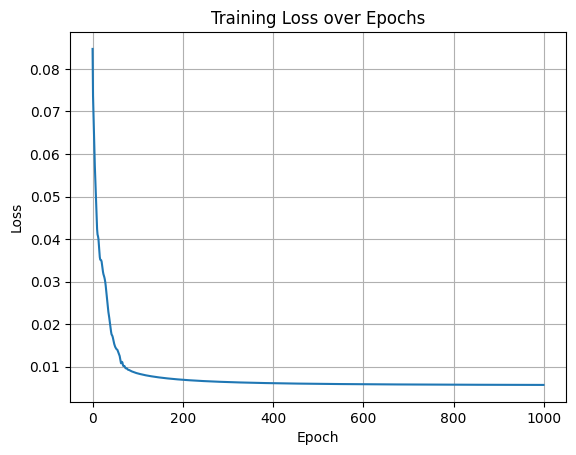

In [409]:
plt.plot(loss_out)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [413]:
sample_size = 700002  # total size you want
target_dist = {
    0.0: int(sample_size * 0.9804549594522818),   # e.g., reduce class 0 to 40%
    1.0: int(sample_size * 0.007296216458923875),
    2.0: int(sample_size * 0.00377970807103106),
    3.0: int(sample_size * 0.008469116017763241),
}

# Build the sample list
samples = []
for k, v in target_dist.items():
    samples.extend([k] * v)

# Shuffle and reshape
np.random.shuffle(samples)
tensor = torch.tensor(samples[:700000],dtype=torch.float32, device=device).reshape(350,2000)
tensor.shape

torch.Size([350, 2000])

In [414]:
values, counts = torch.unique(tensor, return_counts=True)
counts

tensor([686320,   5107,   2645,   5928])

In [461]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 30
n_epochs = 100
lr = 0.005
seed = 20
model = LDMP(tensor, embedding_dim, device, n_epochs, lr, seed)
Aij_probs_true = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

In [462]:
cat, probit = model.predict_categories()
num_different = (tensor != cat).sum().item()
ratio = num_different/(tensor.shape[0]*tensor.shape[1])
print(f"Number of differing entries: {num_different}, ratio: {ratio}")

Number of differing entries: 15569, ratio: 0.02224142857142857


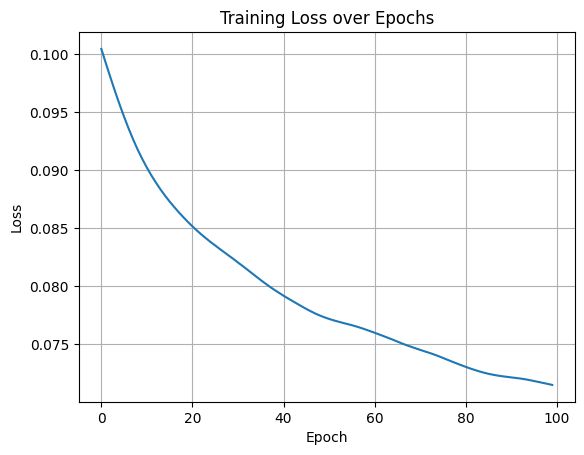

In [463]:
plt.plot(loss_out)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [158]:
NMI, joint_probs = NMI_advanced(Aij_probs_true, Aij_probs_pred)
NMI, joint_probs

(np.float64(0.6168856765578267),
 array([[5.98756164e-01, 2.02935198e-02, 1.27158047e-02, 2.82140894e-02],
        [1.26727686e-03, 4.67308621e-05, 2.94785807e-05, 6.60471694e-05],
        [3.20759558e-03, 1.19009330e-04, 7.51312045e-05, 1.68523467e-04],
        [4.34911332e-03, 1.63457915e-04, 1.03363315e-04, 2.32412795e-04]]))

In [77]:
evaluator = ModelEvaluate(model, Aij)
NMI, probs = evaluator.NMI_advanced()
NMI

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_23706/3212155049.py:208: RuntimeWarning: divide by zero encountered in divide
  MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (joint_true[c] * joint_pred[c_mark]))


array([inf, inf, inf, inf])

In [52]:
results, accs = train_and_evaluate_simple(Aij, embedding_dims, device, holdout_ratio=0.1, n_epochs=500, lr=0.01)
plot_class_accuracy(embedding_dims, accs)

KeyboardInterrupt: 

In [69]:
Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=0.1, seed=20)
model = LDM(Aij_train, embedding_dim=17, device=device, n_epochs=500, lr=0.01, seed=20)
model.train()
Aij_pred, probit_matrix = model.predict_categories()
print("Aij_train:\n", Aij_train, "\nAij_pred:\n", Aij_pred)

Aij_train:
 tensor([[0., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0., 0.],
        [3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.],
        [0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
        [1., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
        [0., 3., 1., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]) 
Aij_pred:
 tensor([[0, 1, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
        [0, 0, 2, 0, 1, 0, 3, 0, 0, 0, 0, 0],
        [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
        [3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
        [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
        [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
        [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 1, 

In [82]:
evaluator = ModelEvaluate(model, Aij, holdout_indices)
nmi_score, joint_probs = evaluator.NMI_basic()
print(f"NMI: {nmi_score:.4f}")

NMI: 0.8385


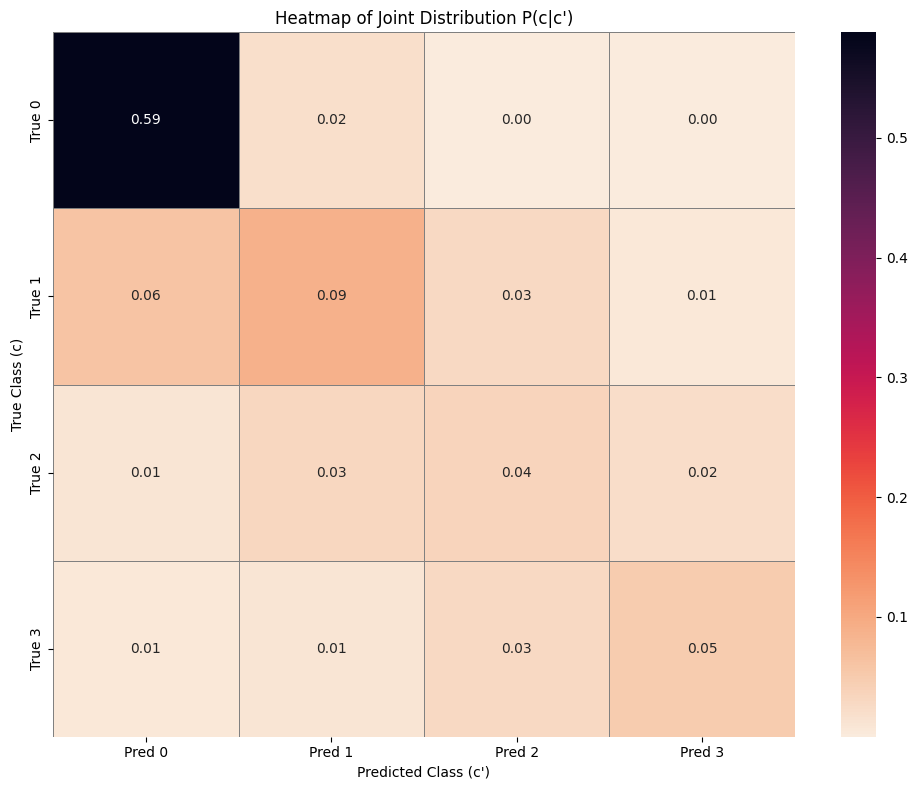

In [79]:
evaluator.plot_heatmap()

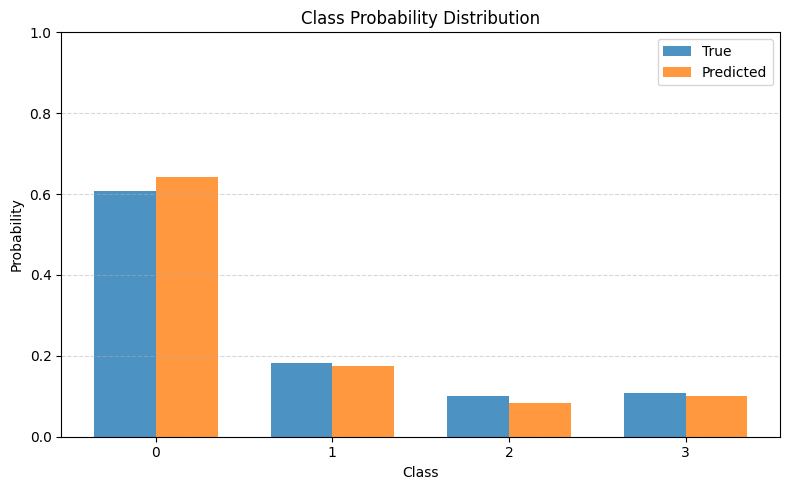

{'true_probs': {np.float64(0.0): np.float64(0.6083333333333333),
  np.float64(1.0): np.float64(0.18333333333333332),
  np.float64(2.0): np.float64(0.1),
  np.float64(3.0): np.float64(0.10833333333333334)},
 'pred_probs': {np.float64(0.0): np.float64(0.6416666666666667),
  np.float64(1.0): np.float64(0.175),
  np.float64(2.0): np.float64(0.08333333333333333),
  np.float64(3.0): np.float64(0.1)}}

In [83]:
evaluator.plot_class_distribution()

In [253]:
# Compare distributions statistically
p_val, true_dist, pred_dist = evaluator.compare_class_distributions()
print(f"Chi-square test p-value: {p_val:.4f}")
if p_val < 0.05:
    print("Distributions are significantly different.")
else:
    print("No significant difference between distributions.")


Chi-square test p-value: 0.8791
No significant difference between distributions.


D=1 | MEAN-AUC-ROC: 0.503 ± 0.014 | MEAN-AUC-PR: 0.187 ± 0.012
D=2 | MEAN-AUC-ROC: 0.537 ± 0.059 | MEAN-AUC-PR: 0.211 ± 0.040
D=3 | MEAN-AUC-ROC: 0.587 ± 0.086 | MEAN-AUC-PR: 0.257 ± 0.084
D=4 | MEAN-AUC-ROC: 0.698 ± 0.138 | MEAN-AUC-PR: 0.399 ± 0.170
D=5 | MEAN-AUC-ROC: 0.621 ± 0.134 | MEAN-AUC-PR: 0.304 ± 0.145
D=6 | MEAN-AUC-ROC: 0.828 ± 0.123 | MEAN-AUC-PR: 0.594 ± 0.201
D=7 | MEAN-AUC-ROC: 0.833 ± 0.116 | MEAN-AUC-PR: 0.601 ± 0.184
D=8 | MEAN-AUC-ROC: 0.842 ± 0.157 | MEAN-AUC-PR: 0.646 ± 0.227
D=9 | MEAN-AUC-ROC: 0.871 ± 0.120 | MEAN-AUC-PR: 0.674 ± 0.183
D=10 | MEAN-AUC-ROC: 0.891 ± 0.091 | MEAN-AUC-PR: 0.707 ± 0.172
D=11 | MEAN-AUC-ROC: 0.845 ± 0.150 | MEAN-AUC-PR: 0.628 ± 0.204
D=12 | MEAN-AUC-ROC: 0.871 ± 0.143 | MEAN-AUC-PR: 0.697 ± 0.221
D=13 | MEAN-AUC-ROC: 0.909 ± 0.115 | MEAN-AUC-PR: 0.782 ± 0.176
D=14 | MEAN-AUC-ROC: 0.865 ± 0.181 | MEAN-AUC-PR: 0.736 ± 0.254
D=15 | MEAN-AUC-ROC: 0.911 ± 0.113 | MEAN-AUC-PR: 0.792 ± 0.173
D=16 | MEAN-AUC-ROC: 0.907 ± 0.112 | MEAN-AUC-PR:

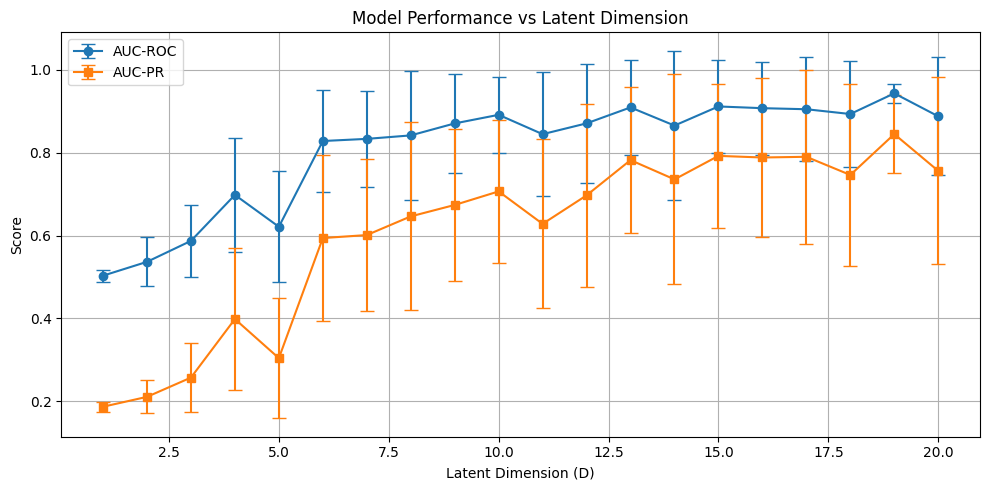

In [254]:
holdout_ratio = 0.1
results, std_aucs, std_prs = train_and_evaluate_bin(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr)
plot_auc(results, std_aucs, std_prs)

In [464]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

class LDM2(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=None):
        super(LDM2, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item() +1

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.gamma = nn.Parameter(torch.randn(1, device=device))
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    

    def get_thresholds(self):
        # Ensure thresholds remain positive and increasing
        deltas = torch.softmax(self.beta_thilde, dim = 0)  # Ensure positive increments
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def probit(self):
        # #n_ordinal_classes = len(self.thresholds) - 1
        # #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_ordinal_classes, self.n_drugs, self.n_effects), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = self.gamma + linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[y, :, :] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    
    def predict_categories(self):
        probit_matrix = self.probit()  # Call probit to get probabilities
        return torch.argmax(probit_matrix, dim=0), probit_matrix
    
    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        freqs = torch.tensor([2685824, 19987, 10354, 23200], dtype=torch.float32, device= self.device)
        class_weights = 1.0 / (freqs + 1e-6)  # Avoid div by 0
        class_weights = class_weights / class_weights.sum()
        probit_matrix = self.probit() 
        # Initialize loss variable
        loss = 0.0

        # Convert Aij to a one-hot encoded tensor
        one_hot_target = torch.zeros(self.n_drugs, self.n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, self.Aij.unsqueeze(-1).long(), 1)  # One-hot encoding

        # Compute the log-likelihood loss efficiently
        prob = probit_matrix  # Shape: (n_ordinal_classes, n_drugs, n_effects)
        # loss = -torch.sum(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        #loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        weighted_log_prob = torch.log(torch.sum(probit_matrix * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8)
        weighted_loss = -torch.sum(weighted_log_prob * (one_hot_target * class_weights.view(1, 1, -1)).sum(dim=2)) / (self.n_drugs * self.n_effects)
        return weighted_loss

    def train(self, print=False):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        #final_loss = None  # Store the last loss
        epoch_losses = []

        for epoch in range(self.n_epochs):
            optimizer.zero_grad()  # Reset gradients
            loss = self.ordinal_cross_entropy_loss()  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            #final_loss = loss.item()  # Store latest loss value
            epoch_losses.append(loss.item())
            if print: 
                if epoch % 10 == 0:  # Print every 10 epochs
                    print(f"Epoch {epoch}/{self.n_epochs}, Loss: {loss.item():.4f}")

        return epoch_losses #,final_loss

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        
    def save_embeddings():
        raise NotImplementedError

In [466]:
def train_and_evaluate_simple(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr, classes=[0, 1, 2, 3]):
    results = []
    class_acc_dict = {c: [] for c in classes}

    for D in embedding_dims:
        all_class_acc = {c: [] for c in classes}

        for i in range(10): 
            #Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            model = LDM2(Aij, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            preds, _ = evaluator._get_predictions()
            true = evaluator._get_true_values()

            class_stats = {c: {'correct': 0, 'total': 0} for c in classes}

            for x in range(preds.shape[0]):
                for y in range(preds.shape[1]):
                    pred_val = preds[x, y]
                    true_val = true[x, y]
                    if pred_val in classes:
                        if pred_val == true_val:
                            class_stats[pred_val]['correct'] += 1
                        class_stats[pred_val]['total'] += 1

            for c in classes:
                correct = class_stats[c]['correct']
                total = class_stats[c]['total']
                acc = correct / total if total > 0 else 0
                all_class_acc[c].append(acc)

        # Mean accuracy across seeds for each class
        for c in classes:
            class_acc_dict[c].append(np.mean(all_class_acc[c]))

        results.append((D, {c: np.mean(all_class_acc[c]) for c in classes}))

    return results, class_acc_dict
    
def plot_class_accuracy(embedding_dims, acc_dict):
    for c in acc_dict:
        plt.plot(embedding_dims, acc_dict[c], marker='o', label=f"Class {c}")

    plt.xlabel("Embedding Dimension")
    plt.ylabel("Mean Accuracy")
    plt.title("Accuracy per Class vs Embedding Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [465]:
#real data
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/LatentDistanceModel/data/filtered_adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([745, 3677])


In [467]:
embedding_dims = [2, 3, 5, 10, 15, 20]
holdout_ratio = 0.1
n_epochs = 1000
lr = 0.005
results, class_acc_dict = train_and_evaluate_simple(Aij_real, embedding_dims, device, holdout_ratio, n_epochs, lr)

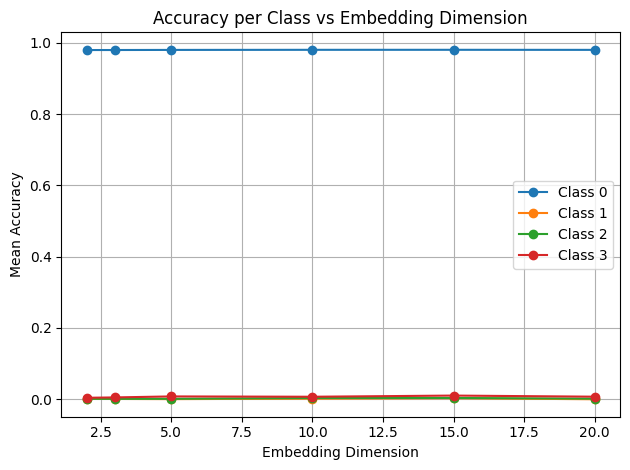

In [468]:
plot_class_accuracy(embedding_dims, class_acc_dict)

In [ ]:
embedding_dims = [2, 3, 5, 10, 15, 20]
holdout_ratio = 0.1
n_epochs = 100
lr = 0.005
results, std_aucs, std_prs = train_and_evaluate_bin(Aij_real, embedding_dims, device, holdout_ratio, n_epochs, lr)
plot_auc(results, std_aucs, std_prs)

D=10 | MEAN-AUC-ROC: 0.619 ± 0.047 | MEAN-AUC-PR: 0.017 ± 0.004
D=15 | MEAN-AUC-ROC: 0.659 ± 0.025 | MEAN-AUC-PR: 0.024 ± 0.002


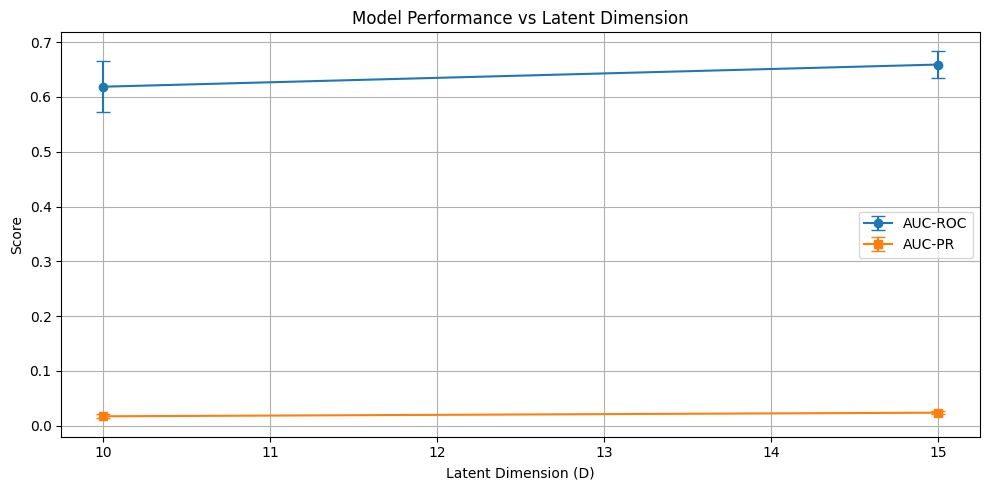

In [470]:
embedding_dims = [10, 15]
holdout_ratio = 0.1
n_epochs = 1000
lr = 0.005
results, std_aucs, std_prs = train_and_evaluate_bin(Aij_real, embedding_dims, device, holdout_ratio, n_epochs, lr)
plot_auc(results, std_aucs, std_prs)

In [474]:
embedding_dim = 15
n_epochs = 1000
lr = 0.005
seed = 20
model = LDMP(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

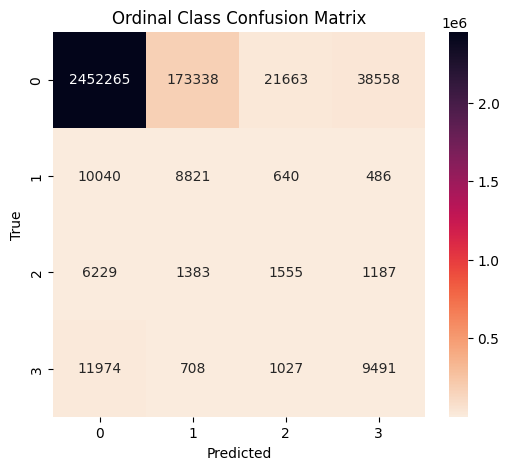


Classification Report:
              precision    recall  f1-score   support

           0      0.989     0.913     0.949   2685824
           1      0.048     0.441     0.086     19987
           2      0.062     0.150     0.088     10354
           3      0.191     0.409     0.260     23200

    accuracy                          0.902   2739365
   macro avg      0.322     0.478     0.346   2739365
weighted avg      0.971     0.902     0.934   2739365

Accuracy per class:
Class 0: 0.913
Class 1: 0.441
Class 2: 0.150
Class 3: 0.409


In [501]:
evaluator = ModelEvaluate(model, Aij_real)
evaluator.plot_confusion()

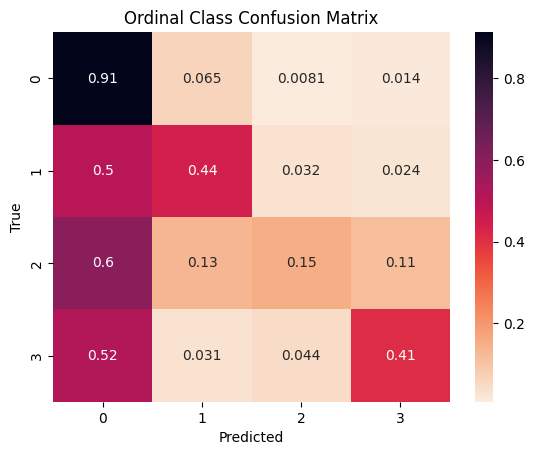

In [497]:
evaluator.plot_confusion_percent()

In [504]:
embedding_dim = 15
n_epochs = 1000
lr = 0.005
seed = 20
model = LDM2(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train() 

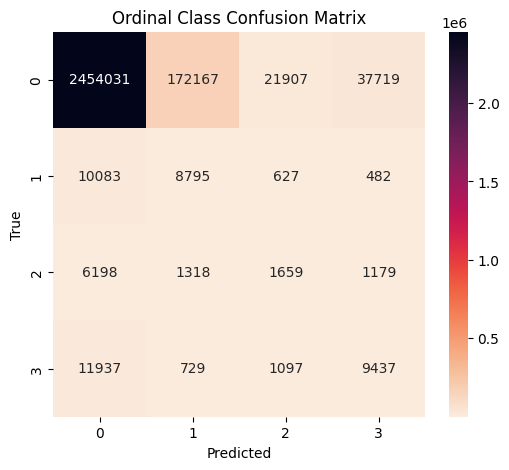


Classification Report:
              precision    recall  f1-score   support

           0      0.989     0.914     0.950   2685824
           1      0.048     0.440     0.087     19987
           2      0.066     0.160     0.093     10354
           3      0.193     0.407     0.262     23200

    accuracy                          0.903   2739365
   macro avg      0.324     0.480     0.348   2739365
weighted avg      0.972     0.903     0.934   2739365

Accuracy per class:
Class 0: 0.914
Class 1: 0.440
Class 2: 0.160
Class 3: 0.407


In [506]:
evaluator = ModelEvaluate(model, Aij_real)
evaluator.plot_confusion()

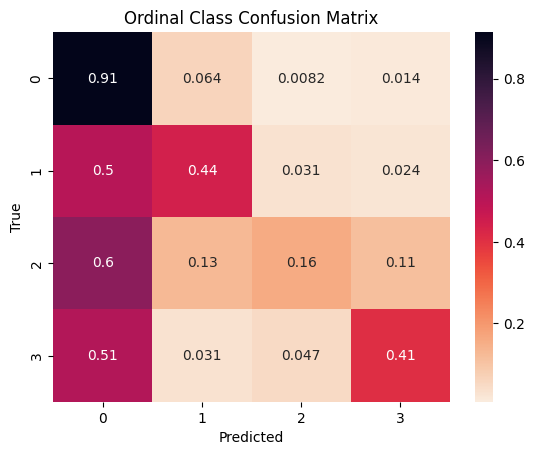

In [507]:
evaluator.plot_confusion_percent()

## Training Multiple Models

### Embedding dim=2

In [57]:
embedding_dim = 2
n_epochs =100
lr = 0.01
seed1 = 20
seed2 = 42

model = LDMP(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

model2 = LDMP(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()  # Compute the ordinal cross-entropy loss

In [58]:
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.8922120506674133),
 array([[1.70109192e-01, 9.42904848e-03, 1.33388967e-03, 1.31684167e-03],
        [8.40910554e-04, 6.96472691e-05, 1.00066097e-05, 9.90926344e-06],
        [8.06955502e-04, 6.70641756e-05, 9.63952520e-06, 9.54675912e-06],
        [1.61154455e-03, 1.34558625e-04, 1.93529381e-05, 1.91697295e-05]]))

#### Learning rate change

In [43]:
embedding_dim = 2
n_epochs =100
lr = 0.05
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.8922120506674133),
 array([[1.70109192e-01, 9.42904848e-03, 1.33388967e-03, 1.31684167e-03],
        [8.40910554e-04, 6.96472691e-05, 1.00066097e-05, 9.90926344e-06],
        [8.06955502e-04, 6.70641756e-05, 9.63952520e-06, 9.54675912e-06],
        [1.61154455e-03, 1.34558625e-04, 1.93529381e-05, 1.91697295e-05]]))

In [42]:
#Variables
embedding_dim = 2
n_epochs =100
lr = 0.005
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.8922120506674133),
 array([[1.70109192e-01, 9.42904848e-03, 1.33388967e-03, 1.31684167e-03],
        [8.40910554e-04, 6.96472691e-05, 1.00066097e-05, 9.90926344e-06],
        [8.06955502e-04, 6.70641756e-05, 9.63952520e-06, 9.54675912e-06],
        [1.61154455e-03, 1.34558625e-04, 1.93529381e-05, 1.91697295e-05]]))

In [44]:
#Variables
embedding_dim = 2
n_epochs =100
lr = 0.01
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.8922120506674133),
 array([[1.70109192e-01, 9.42904848e-03, 1.33388967e-03, 1.31684167e-03],
        [8.40910554e-04, 6.96472691e-05, 1.00066097e-05, 9.90926344e-06],
        [8.06955502e-04, 6.70641756e-05, 9.63952520e-06, 9.54675912e-06],
        [1.61154455e-03, 1.34558625e-04, 1.93529381e-05, 1.91697295e-05]]))

#### Changing epochs

In [ ]:
#Variables
embedding_dim = 2
n_epochs =50
lr = 0.01
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

#### Hold-out

In [59]:
embedding_dim = 2
n_epochs =100
lr = 0.01
seed = 42

Aij_train, holdouts = create_holdout(Aij_real, holdout_ratio=0.1, seed=42)

model = LDMP(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

model2 = LDMP(Aij_train, embedding_dim, device, n_epochs, lr, seed)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()  # Compute the ordinal cross-entropy loss

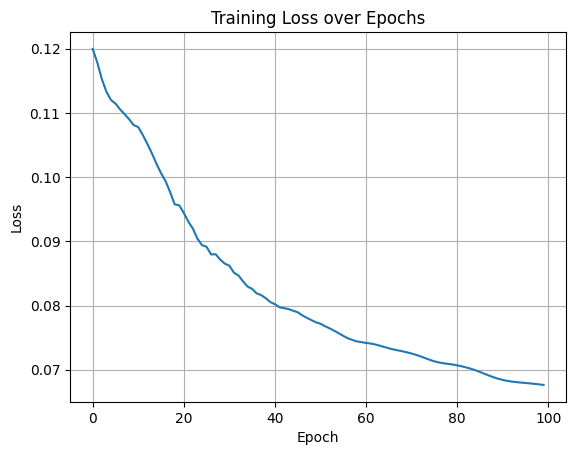

In [61]:
plt.plot(loss_out)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

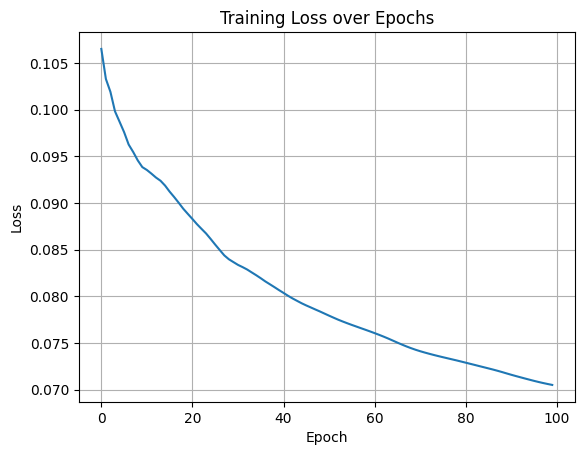

In [60]:
plt.plot(loss_out2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [68]:
evaluator = ModelEvaluate(model, Aij_real)
auc_roc, auc_pr = evaluator.evaluate_binary()
auc_roc, auc_pr

(np.float64(0.5186698979359979), np.float64(0.020499283164409885))

In [71]:
auc_roc, auc_pr = evaluator.evaluate_()
auc_roc, auc_pr

(np.float64(0.526428844322659), np.float64(0.009124956166759474))